In [1]:
!pip install pandas
!pip install seaborn

In [2]:
import simpy
import random
import numpy as np

## **Ejercicio 2**

In [3]:
class Servidor:
    def __init__(self, env, id_servidor):
        self.env = env
        self.id_servidor = id_servidor
        self.procesador = simpy.Resource(env, capacity=1)
        self.carga = 0

    def procesar(self, solicitud):
        # el tiempo de procesamiento del servidor sigue una distribución exponencial
        tiempo_procesamiento = random.expovariate(1 / TIEMPO_PROCESAMIENTO_PROM)
        self.carga += 1
        yield self.env.timeout(tiempo_procesamiento)
        tiempos_atencion_servidores.append(tiempo_procesamiento)
        self.carga -= 1

In [4]:
class BalanceadorRoundRobin:
    def __init__(self, env, servidores):
        if env is not None:
            self.env = env
            self.procesador = simpy.Resource(env, capacity=1)
        self.servidores = servidores
        self.ultimo_servidor = 0

    def balancear(self, solicitud):
        servidor = None
        with self.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_balanceador.append(self.env.now- tiempo_inicio_espera)
            yield self.env.timeout(TIEMPO_BALANCEADOR)
            servidor = self.seleccionar_servidor()
        
        with servidor.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_servidores.append(self.env.now - tiempo_inicio_espera)
            yield self.env.process(servidor.procesar(solicitud))

    def seleccionar_servidor(self):
        servidor = self.servidores[self.ultimo_servidor]
        self.ultimo_servidor = (self.ultimo_servidor + 1) % len(self.servidores)
        return servidor


In [5]:
class BalanceadorDifuso:
    def __init__(self, env, servidores, grafo, umbral):
        self.env = env
        self.servidores = servidores
        self.balanceador_round_robin = BalanceadorRoundRobin(None, servidores)
        self.procesador = simpy.Resource(env, capacity=1)
        self.grafo = grafo
        self.umbral = umbral

    def balancear(self, solicitud):
        servidor = None
        with self.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_balanceador.append(self.env.now - tiempo_inicio_espera)
            yield self.env.timeout(TIEMPO_BALANCEADOR)
            servidor = self.seleccionar_servidor()

        with servidor.procesador.request() as req:
            tiempo_inicio_espera = self.env.now
            yield req
            tiempos_espera_cola_servidores.append(self.env.now - tiempo_inicio_espera)
            yield self.env.process(servidor.procesar(solicitud))

    def seleccionar_servidor(self):
        # selecciona un servidor con menor carga siguiendo el grafo y el umbral de carga
        servidor_inicial = self.balanceador_round_robin.seleccionar_servidor() # round robin como dice en el paper
        return self.propagacion_difusa(servidor_inicial)

    def propagacion_difusa(self, servidor_actual):
        # busca el servidor menos cargado entre los vecinos si la diferencia de carga excede el umbral
        visitados = set()  # para evitar ciclos en el grafo
        cola = [servidor_actual]

        while cola:
            servidor = cola.pop(0)
            visitados.add(servidor.id_servidor)

            vecinos = [self.servidores[vid] for vid in self.grafo[servidor.id_servidor] if vid not in visitados]
            if not vecinos:
                break  # no hay vecinos a los que propagar

            servidor_menos_cargado = min(vecinos, key=lambda s: s.carga)
            diferencial_carga = servidor.carga - servidor_menos_cargado.carga

            if diferencial_carga > self.umbral:
                cola.append(servidor_menos_cargado)  # propaga al vecino menos cargado
            else:
                return servidor  # retorna el servidor actual si la carga es aceptable

        return servidor_actual  # devuelve el servidor inicial si no se encontró uno mejor

In [6]:
def generar_solicitudes(env, balanceador):
    solicitud_id = 0

    for _ in range(CANTIDAD_SOLICITUDES):
        env.process(balanceador.balancear(solicitud_id))
        solicitud_id += 1
        yield env.timeout(random.expovariate(TASA_SOLICITUDES))

In [7]:
def simular(tecnica, num_servidores):
    env = simpy.Environment()
    servidores = [Servidor(env, i) for i in range(num_servidores)]
    
    if tecnica == "Difuso":
        balanceador = BalanceadorDifuso(env, servidores, grafo, UMBRAL_PROPAGACION)
    elif tecnica == "Round Robin":
        balanceador = BalanceadorRoundRobin(env, servidores)
    else:
        raise ValueError("Técnica no soportada en esta simulación")

    env.process(generar_solicitudes(env, balanceador))
    env.run()

In [8]:
def mostrar_resultados():
    print("Media de espera en cola de balanceador:", np.mean(tiempos_espera_cola_balanceador))
    print("Media de espera en cola de servidores:", np.mean(tiempos_espera_cola_servidores))
    print("Media de atención en servidores:", np.mean(tiempos_atencion_servidores))
    print()

    print("Mediana de espera en cola de balanceador:", np.median(tiempos_espera_cola_balanceador))
    print("Mediana de espera en cola de servidores:", np.median(tiempos_espera_cola_servidores))
    print("Mediana de atención en servidores:", np.median(tiempos_atencion_servidores))
    print()
    
    print("Desviación estándar de espera en cola del balanceador:", np.std(tiempos_espera_cola_balanceador))
    print("Desviación estándar de espera en cola de servidores:", np.std(tiempos_espera_cola_servidores))
    print("Desviación estándar de atención en servidores:", np.std(tiempos_atencion_servidores))

In [9]:
import pandas as pd

def armar_configuracion(df, configuracion, tecnica):
    configuracion = [configuracion] * 3
    tecnica = [tecnica] * 3
    media = df.mean().to_frame(name = "Media")
    mediana = df.median().to_frame(name = "Mediana")
    desvio_estandar = df.std().to_frame(name = "Desvío estándar")
    resultado = media.join(mediana).join(desvio_estandar)
    resultado["Configuracion"] = configuracion
    resultado["Técnica"] = tecnica
    resultado = resultado.reset_index().rename(columns = {"index": "Métrica"})
    return resultado

def concatenar_metricas(configuraciones):
    return pd.concat(configuraciones).reset_index().drop(columns = "index")

def definir_metricas():
    metricas = {"Espera cola balanceador": tiempos_espera_cola_balanceador,
                "Espera cola servidores": tiempos_espera_cola_servidores,
                "Atención cola servidores": tiempos_atencion_servidores}
    return metricas

### **Parámetros comunes**

In [10]:
CANTIDAD_SOLICITUDES = 100_000
UMBRAL_PROPAGACION = 5 # Diferencia de carga para propagación en balanceador difuso

# Definición de la red de servidores en forma de grafo (lista de adyacencia)

### **Configuración 1**

In [11]:
# Parámetros de la simulación
TASA_SOLICITUDES = 10                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.1           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 1     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [12]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_1 = pd.DataFrame(metricas_rr)
config_rr_1 = armar_configuracion(df_rr_1, 1, "Round Robin")
df_rr_1["Configuracion"] = [1] * CANTIDAD_SOLICITUDES
config_rr_1

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,9.244606,8.433914,6.762563,1,Round Robin
1,Espera cola servidores,5018.893076,5034.078090,2902.738736,1,Round Robin
2,Atención cola servidores,1.002771,0.697686,0.997713,1,Round Robin


#### Difuso

In [13]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_1 = pd.DataFrame(metricas_d)
config_d_1 = armar_configuracion(df_d_1, 1, "Difuso")
df_d_1["Configuracion"] = [1] * CANTIDAD_SOLICITUDES
config_d_1

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,10.094755,8.732166,6.195171,1,Difuso
1,Espera cola servidores,5062.833407,5078.750162,2910.183891,1,Difuso
2,Atención cola servidores,1.005021,0.696992,1.001878,1,Difuso


### **Configuración 2**

In [14]:
# Parámetros de la simulación
TASA_SOLICITUDES = 20                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.05           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 0.50     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                  # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [15]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_2 = pd.DataFrame(metricas_rr)
config_rr_2 = armar_configuracion(df_rr_2, 2, "Round Robin")
df_rr_2["Configuracion"] = [2] * CANTIDAD_SOLICITUDES
config_rr_2

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,4.955865,4.892219,3.102666,2,Round Robin
1,Espera cola servidores,2498.337652,2500.138717,1443.867226,2,Round Robin
2,Atención cola servidores,0.499961,0.345891,0.500276,2,Round Robin


#### Difuso

In [16]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_2 = pd.DataFrame(metricas_d)
config_d_2 = armar_configuracion(df_d_2, 2, "Difuso")
df_d_2["Configuracion"] = [2] * CANTIDAD_SOLICITUDES
config_d_2

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,7.932679,8.210979,3.712622,2,Difuso
1,Espera cola servidores,2473.185513,2478.906623,1427.456460,2,Difuso
2,Atención cola servidores,0.497797,0.343632,0.499732,2,Difuso


### **Configuracion 3**

In [17]:
# Parámetros de la simulación
TASA_SOLICITUDES = 40                # Tasa de llegada de solicitudes en solicitudes/segundo (poisson)
TIEMPO_BALANCEADOR = 0.025           # Tiempo que toma al balanceador derivar la solicitud en segundos
TIEMPO_PROCESAMIENTO_PROM = 0.25     # Tiempo promedio de procesamiento en segundos de los servidores

NUM_SERVIDORES = 5                  # Número de servidores
grafo = {
    0: [1, 2],
    1: [3, 4],
    2: [3, 4],
    3: [0, 1],
    4: [0, 1]
}

#### Round Robin

In [18]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Round Robin", NUM_SERVIDORES)
metricas_rr = definir_metricas()
df_rr_3 = pd.DataFrame(metricas_rr)
config_rr_3 = armar_configuracion(df_rr_3, 3, "Round Robin")
df_rr_3["Configuracion"] = [3] * CANTIDAD_SOLICITUDES
config_rr_3

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,9.652096,9.558445,3.753386,3,Round Robin
1,Espera cola servidores,1259.591760,1260.759164,723.752482,3,Round Robin
2,Atención cola servidores,0.250310,0.174008,0.250129,3,Round Robin


#### Difuso

In [19]:
# Inicialización de métricas
tiempos_espera_cola_balanceador = [] # Tiempos de espera entre la llegada de una solicitud al balanceador y la atencion del mismo
tiempos_espera_cola_servidores = []  # Tiempos de espera entre la llegada de una solicitud al servidor y la atencion del mismo
tiempos_atencion_servidores = []     # Tiempos de procesamiento de las solicitudes en el servidor

simular("Difuso", NUM_SERVIDORES)
metricas_d = definir_metricas()
df_d_3 = pd.DataFrame(metricas_d)
config_d_3 = armar_configuracion(df_d_3, 3, "Difuso")
df_d_3["Configuracion"] = [3] * CANTIDAD_SOLICITUDES
config_d_3

,Métrica,Media,Mediana,Desvío estándar,Configuracion,Técnica
0,Espera cola balanceador,8.055437,8.627589,3.309674,3,Difuso
1,Espera cola servidores,1243.543762,1237.059592,723.862233,3,Difuso
2,Atención cola servidores,0.250136,0.173515,0.249980,3,Difuso


### **Combinar Resultados**

In [20]:
resultados = [config_rr_1, config_d_1, config_rr_2, config_d_2, config_rr_3, config_d_3]
distribuciones = [df_rr_1, df_d_1, df_rr_2, df_d_2, df_rr_3, df_d_3]
combinacion = concatenar_metricas(resultados)
combinaciones_dist = concatenar_metricas(distribuciones)

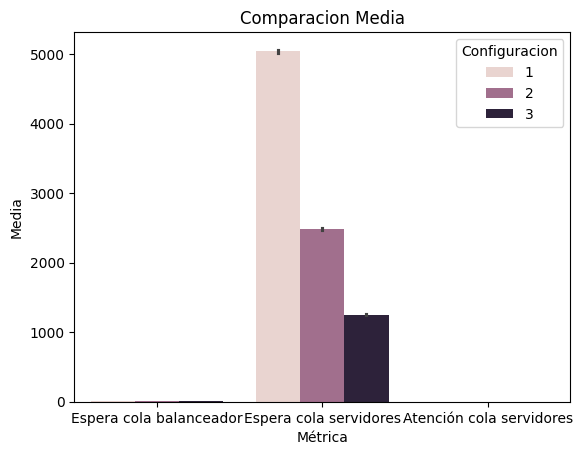

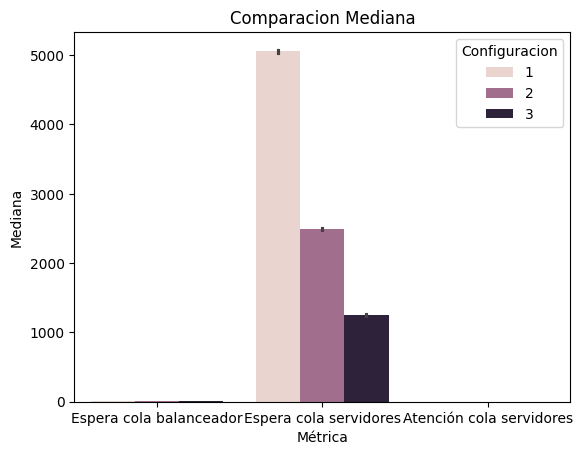

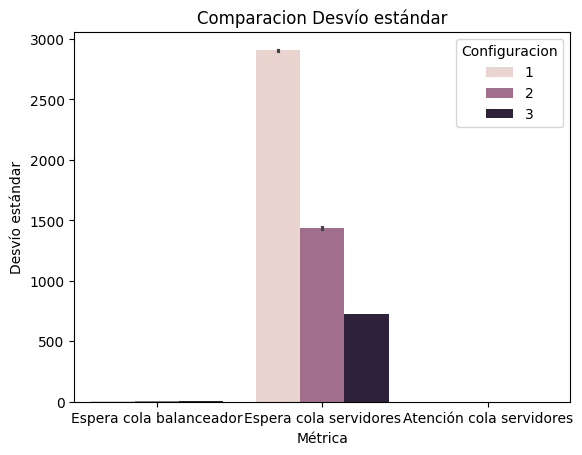

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_compraracion(metrica):
    sns.barplot(x = "Métrica", y = metrica, hue = "Configuracion", data = combinacion)
    
    plt.title(f"Comparacion {metrica}")
    plt.show()

plot_compraracion("Media")
plot_compraracion("Mediana")
plot_compraracion("Desvío estándar")

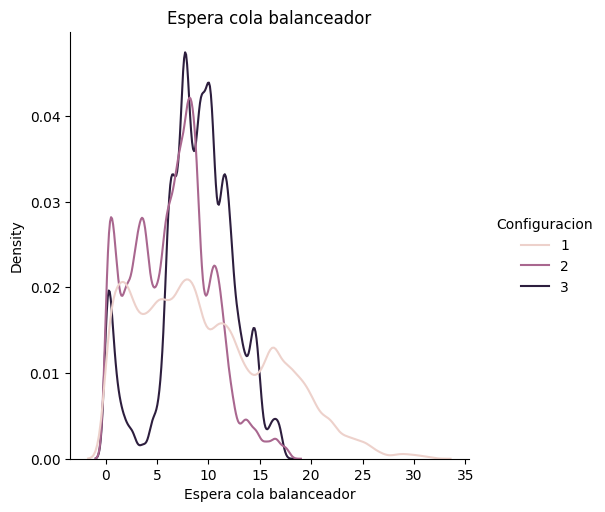

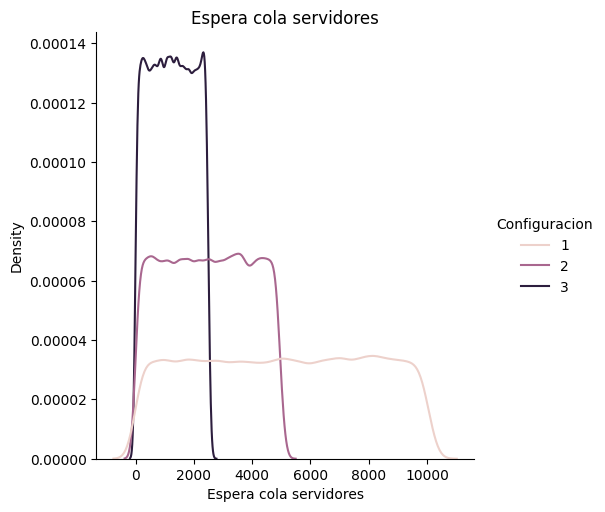

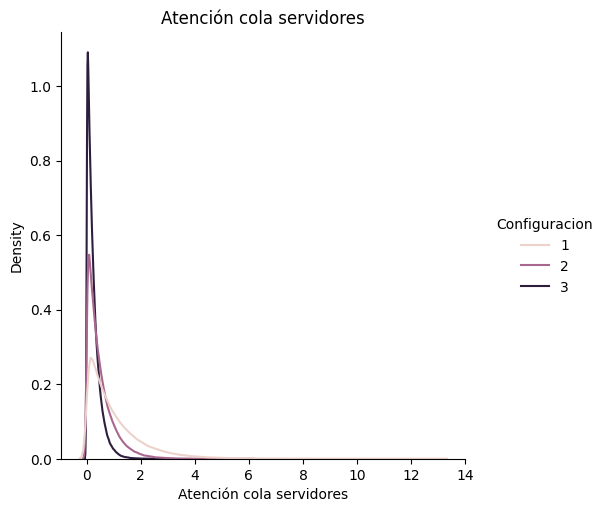

In [22]:
def comparar_distribuciones(distribucion):
    sns.displot(data = combinaciones_dist, x = distribucion, 
                kind = "kde", hue = "Configuracion")
    plt.title(distribucion)
    plt.show()
comparar_distribuciones("Espera cola balanceador")
comparar_distribuciones("Espera cola servidores")
comparar_distribuciones("Atención cola servidores")